<a href="https://colab.research.google.com/github/peenalGupta/Data-Analytics-3-Labs/blob/main/07_Animal_Classification_AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print(tf.__version__)

2.17.1


# Loading the data

In [ ]:
!wget https://storage.googleapis.com/adsa-data/animal-classification/animal.zip
!unzip animal.zip -d temp

In [3]:
!mkdir -p data/dog
!mkdir -p data/cat
!cp temp/train/dog.* data/dog/
!cp temp/train/cat.* data/cat/

In [4]:
import os

dog_count = len(os.listdir("./data/dog"))
cat_count = len(os.listdir("./data/cat"))
print("Dog pictures: ", dog_count)
print("Cat pictures: ", cat_count)

Dog pictures:  12500
Cat pictures:  12500


# Load data into Dataset objects

In [12]:
IMAGE_WIDTH=227
IMAGE_HEIGHT=227
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
BATCH_SIZE=32

In [13]:
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

# TODO Use tf.keras.utils.image_dataset_from_directory to assign 80% images to the train dataset
(train_ds, val_ds) = tf.keras.utils.image_dataset_from_directory(
    './data',
    labels='inferred',
    label_mode='binary',
    image_size=IMAGE_SIZE,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset='both',
    seed=123,
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Using 5000 files for validation.


In [14]:
class_names = train_ds.class_names
print(class_names)

['cat', 'dog']


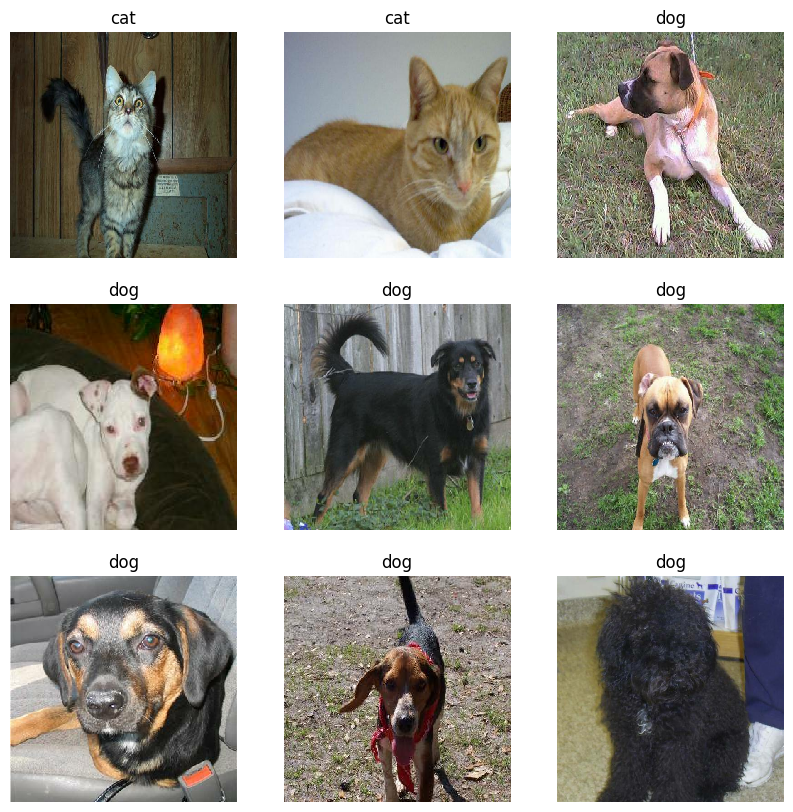

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    label_index = int(labels[i])
    plt.title(class_names[label_index])
    plt.axis("off")

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Model Preparation

In [16]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',patience = 2,verbose = 1,factor = 0.5,min_lr = 0.00001)
callbacks = [earlystop,learning_rate_reduction]

In [22]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

#from tensorkeras.layers.normalization import BatchNormalization

# TODO: Design an AlexNet model
model = keras.models.Sequential()

#1 Conv Layer
model.add(keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4),padding = "same",
                              activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)))

#1 Max Pool Layer
model.add(keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)))
model.add(tf.keras.layers.BatchNormalization())

#2 Conv Layer
model.add(keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding="same",
                              activation='relu'))

#2 Max pool Layer
model.add(keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)))
model.add(tf.keras.layers.BatchNormalization())

#3 Conv Layer
model.add(keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding="same",
                              activation='relu'))

#4 Conv Layer
model.add(keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding="same",
                              activation='relu'))

#5 Conv Layer
model.add(keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding="same",
                              activation='relu'))

#3 Max Pool Layer
model.add(keras.layers.MaxPool2D(pool_size=(3,3),strides=(2,2)))
model.add(tf.keras.layers.BatchNormalization())

model.add(Flatten())

#1 dense layer
model.add(keras.layers.Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(tf.keras.layers.BatchNormalization())

#2 dense layer
model.add(keras.layers.Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(tf.keras.layers.BatchNormalization())

#3 dense layer
model.add(keras.layers.Dense(1000, activation='relu'))
model.add(Dropout(0.5))
model.add(tf.keras.layers.BatchNormalization())

#output layer
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

# model.compile(
#     optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001),
#     loss=SparseCategoricalCrossentropy(),
#     metrics=['accuracy'])

model.compile(
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001),
    loss='BinaryCrossentropy', # Use BinaryCrossentropy for binary classification
    metrics=['accuracy'])



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)                   │ (None, 57, 57, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 28, 28, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 28, 28, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 28, 28, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 13, 13, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 13, 13, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 13, 13, 384)         │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 13, 13, 384)         │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 13, 13, 256)         │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 6, 6, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4096)                │      37,752,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 4096)                │          16,384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 4096)                │          16,384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1000)                │       4,097,0

 Total params: 62,418,545 (238.11 MB)

 Trainable params: 62,398,945 (238.03 MB)

 Non-trainable params: 19,600 (76.56 KB)

In [ ]:
epochs = 10

train = model.fit(
    train_ds,
    epochs=epochs,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    callbacks=callbacks
)

Epoch 1/10
105/625 ━━━━━━━━━━━━━━━━━━━━ 57:46 7s/step - accuracy: 0.5364 - loss: 0.8626

# Visualization

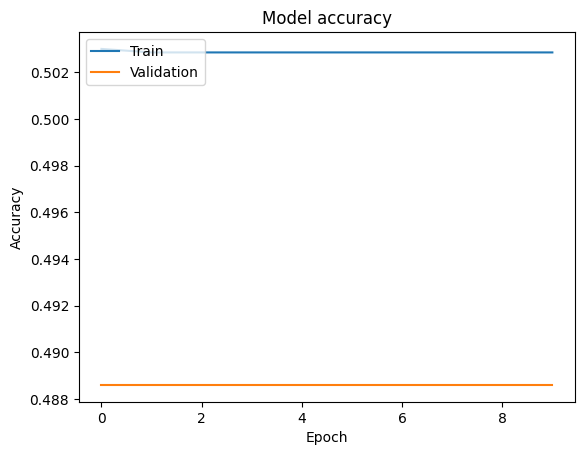

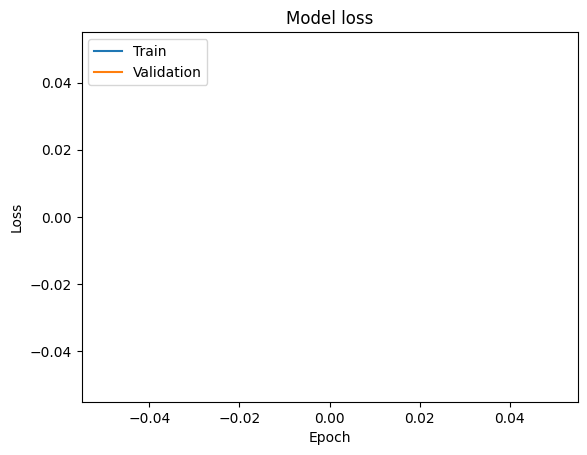

In [ ]:
# TODO: Plot loss and accuracy
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(train.history['accuracy'])
plt.plot(train.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(train.history['loss'])
plt.plot(train.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Confusion Matrix

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step


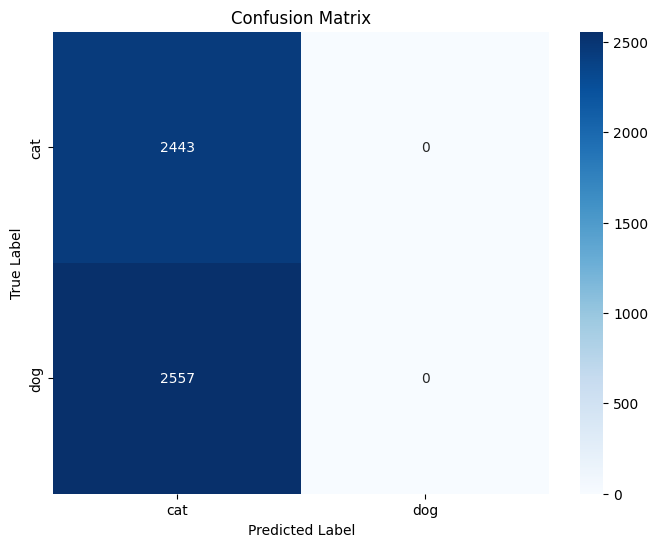

In [ ]:
# TODO: Draw confusion matrix
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get the true labels and predicted labels for the validation set
y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_pred = model.predict(val_ds).flatten()
y_pred = np.where(y_pred > 0.5, 1, 0) # Convert probabilities to binary predictions

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Testing

In [ ]:
!wget https://storage.googleapis.com/adsa-data/animal-classification/test.zip
!unzip test.zip

--2024-12-14 23:03:21--  https://storage.googleapis.com/adsa-data/animal-classification/test.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.145.207, 74.125.128.207, 74.125.143.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.145.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 370194 (362K) [application/zip]
Saving to: ‘test.zip’

test.zip            100%[===================>] 361.52K  --.-KB/s    in 0.1s    

2024-12-14 23:03:22 (2.96 MB/s) - ‘test.zip’ saved [370194/370194]

Archive:  test.zip
   creating: test/
  inflating: test/cat1.jpg           
  inflating: test/cat2.jpg           
  inflating: test/cat3.jpg           
  inflating: test/dog1.jpg           
  inflating: test/dog2.jpg           
  inflating: test/dog3.jpg           


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


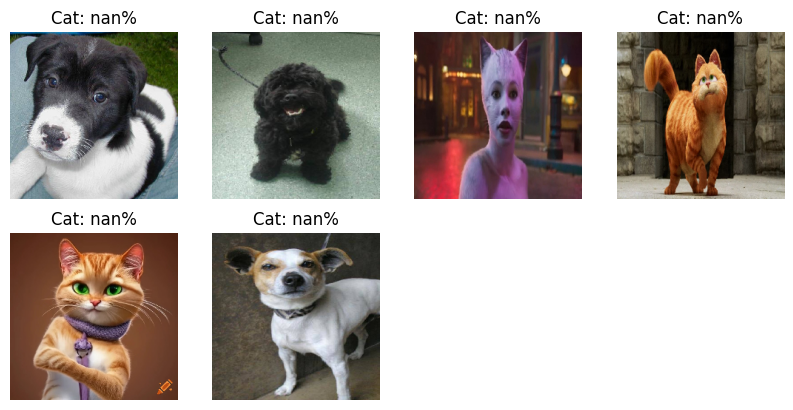

In [ ]:
import glob
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

plt.figure(figsize=(10, 10))
for i, file in enumerate(glob.glob('test/*')):
    img = load_img(file, target_size=IMAGE_SIZE)

    # convert to array
    img = img_to_array(img)
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(img.astype("uint8"))

    # reshape into a single sample with 3 channels
    img = img.reshape(1, IMAGE_WIDTH, IMAGE_HEIGHT, 3)
    predict = model.predict(img)
    percent = predict[0][0]*100

    result = 'Cat'
    if percent < 50:
        result = 'Dog'
        percent = 100 - percent

    plt.title(result + ": " + str(round(percent, 2)) + "%")
    plt.axis("off")

# Improvement

In [ ]:
# Did you forget to Rescale the images?
# TODO: Add a Rescaling layer at the top of the model
# https://keras.io/api/layers/preprocessing_layers/image_preprocessing/rescaling/

In [ ]:
# Did you have Overfit?
# TODO: Try to add some data argumentation layers (RandomZoom, RandomFlip, RandomRotation, RandomTranslation) after the Rescaling layer and train again